| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  | Metropolis and Gibbs Samplers and MCMC Metrics - Metropolis Sampler |
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 01/15/21 |

In [1]:
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm, mode
import tensorflow_probability as tfp # for effective sample size

In [2]:
# Utility functions
np.random.seed(123)

# For Metropolis sampler
rnorm = lambda step_size: np.random.normal(scale = step_size, size = 1)
cdfnorm = lambda l,s: norm.cdf(0,loc = l, scale = s)
runif = lambda: np.random.uniform(size = 1)

# Conjugate check
# rgamma = lambda alpha, beta: np.random.gamma(shape = alpha, rate=beta, size = 1)

In [3]:
# Constants
np.random.seed(123)
n_iter = 5000
y =  [4827, 4985, 5010, 5203, 5138]

In [4]:
# Metropolis Sampler for Poisson Gamma
def metropolis_sampler_poisson_gamma(y, alpha,beta,
                                     step_size = 1,burn_in = 500,
                                     seed = 123):
    
    # Constants
    np.random.seed(seed)
    alpha = alpha; beta = beta # Prior parameters
    lambda_post = np.ones(n_iter+burn_in) # Pre-allocation array
    alpha_prime = (sum(y) + alpha-1)
    beta_prime =  (beta+len(y))

    # Initial value
    lambda_post[0] = np.mean(y)-5

    for i in range(1,n_iter+burn_in):
        
        # Constants
        lambda_proposed = lambda_post[i-1] + rnorm(step_size)

        # Scale correction factor
        required_boundary_correction = False

        # Boundary correction
        while(lambda_proposed<0):
            lambda_proposed = lambda_post[i-1] + rnorm(step_size)

        # Accept/reject criteria
        a = alpha_prime * (np.log(lambda_proposed) - np.log(lambda_post[i-1])) - \
            beta_prime * (lambda_proposed - lambda_post[i-1])
        
        boundary_correction = np.log((1-cdfnorm(lambda_post[i-1],1)) - np.log((1-cdfnorm(lambda_proposed,1))))

        log_u = np.log(runif())
        if (min(a,0)>log_u):
            # Accept sample
            lambda_post[i] = lambda_proposed
        else:
            # Reject sample
            lambda_post[i] = lambda_post[i-1]

    return(lambda_post[burn_in:])

In [5]:
# Defining the autocorrelation function
def acf(x, t=100):
   autocorrelations = np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  for i in range(1, t)])
   out = pd.DataFrame({'autocorrelation':autocorrelations}).reset_index().rename({'index':'lag'}, axis = 1)
   return(out)

In [6]:
v = metropolis_sampler_poisson_gamma(y,alpha = 0.005,beta = 0.005, step_size = 20)
acf_metro = acf(v)
acf_metro

,lag,autocorrelation
0,0,1.000000
1,1,0.893784
2,2,0.797470
3,3,0.713134
4,4,0.638568
...,...,...
95,95,0.043742
96,96,0.033264
97,97,0.025245
98,98,0.018647


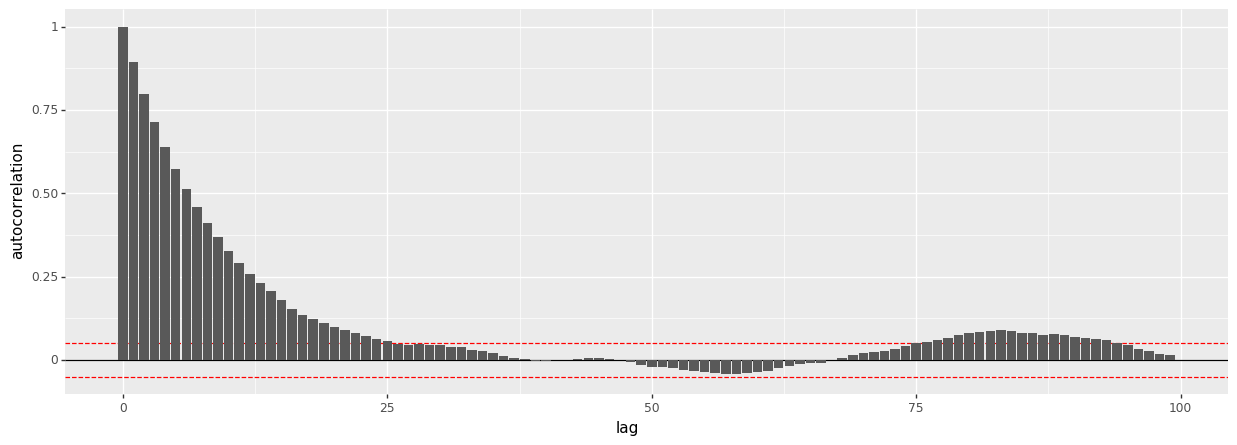

<ggplot: (373881194)>

In [7]:
def plot_acf(data_in, figure_size = (15,5)):
    pn.options.figure_size = figure_size
    plot_out = pn.ggplot(pn.aes(x = 'lag', y = 'autocorrelation'), data = data_in)\
        + pn.geom_hline(pn.aes(yintercept= 0))\
        + pn.geom_hline(pn.aes(yintercept= 0.05), color = 'red', linetype = 'dashed')\
        + pn.geom_hline(pn.aes(yintercept= -0.05), color = 'red', linetype = 'dashed')\
        + pn.geom_col()
    return(plot_out)

plot_acf(acf_metro)

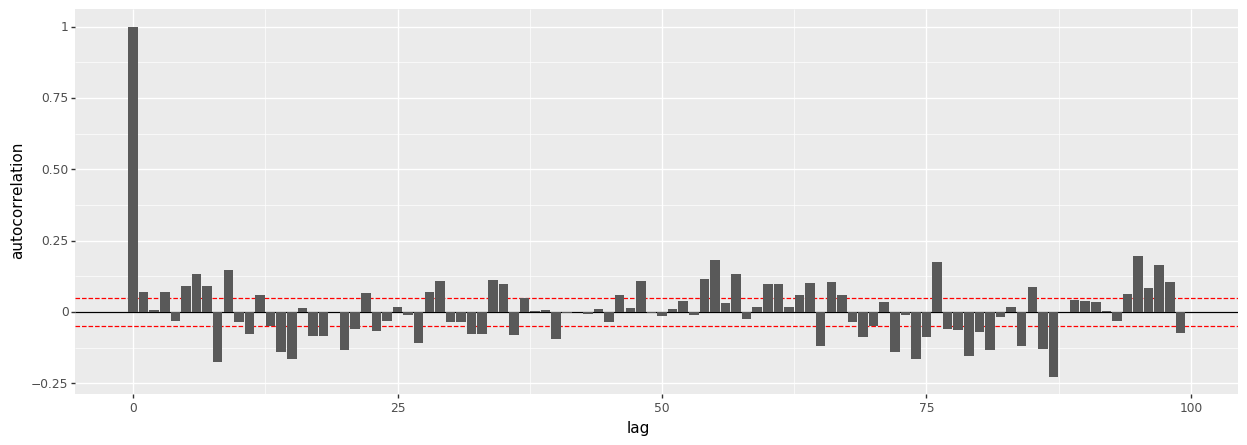

<ggplot: (373877603)>

In [8]:
# Thin sample
# Step size is too large, we need to thin the sample
plot_acf(acf(v[::25]))

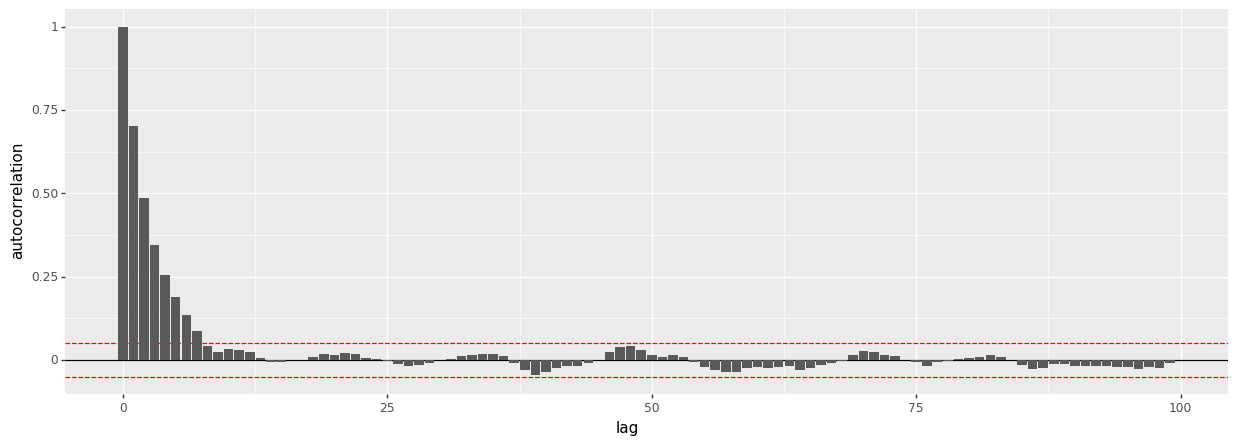

<ggplot: (374055393)>

In [9]:
# Let's increase the step_size
v_2 = metropolis_sampler_poisson_gamma(y,alpha = 0.005,beta = 0.005, step_size = 50)
plot_acf(acf(v_2))

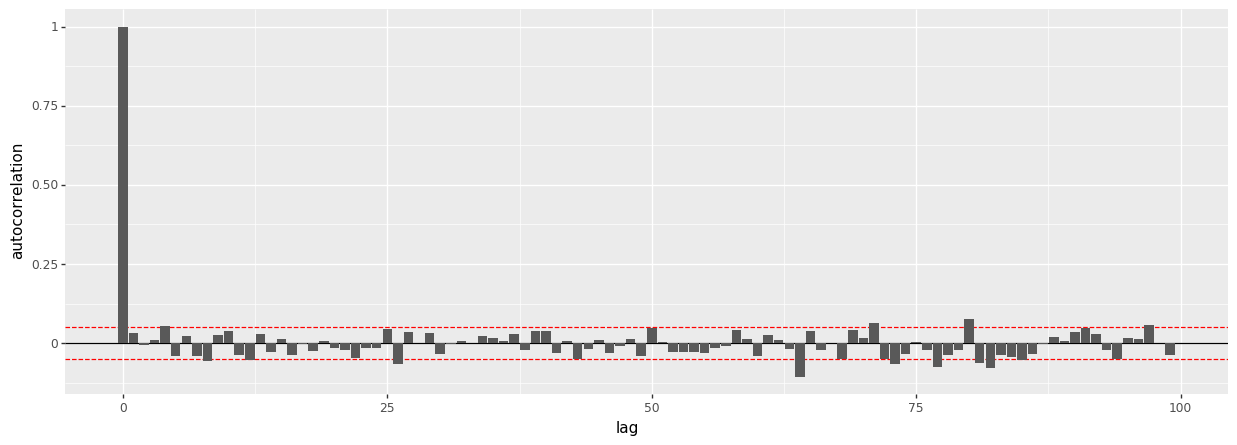

<ggplot: (374061362)>

In [10]:
# Looks like autcorrelation is below at lag 7, let's select every 8th sample
v_3 = v_2[::8]
plot_acf(acf(v_3))

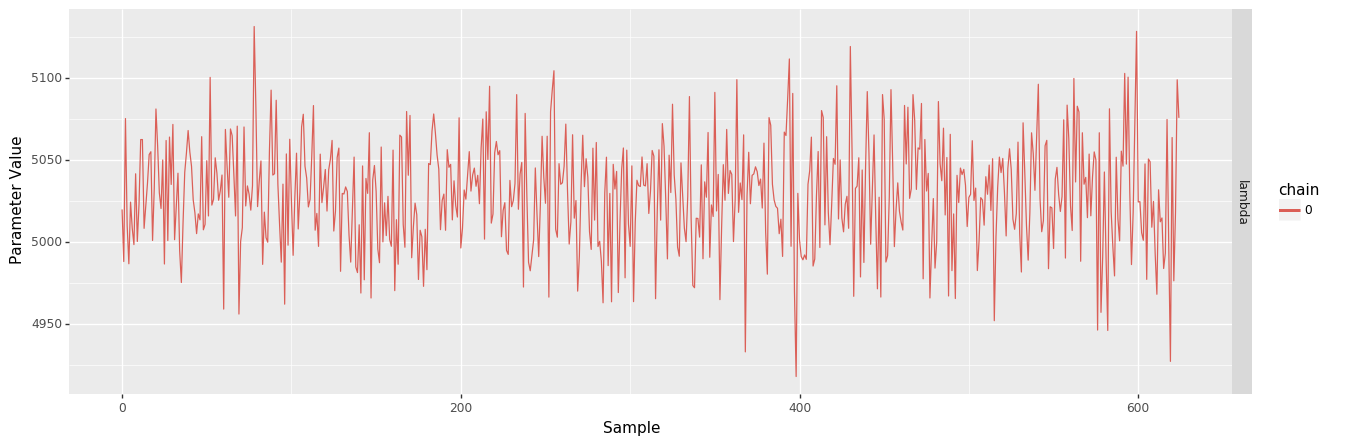

<ggplot: (374139284)>


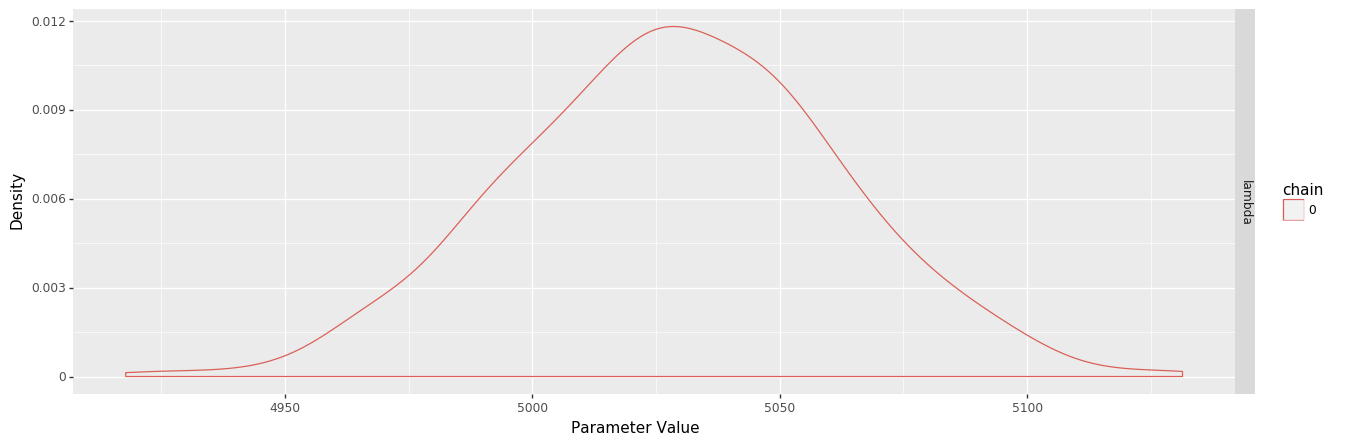

<ggplot: (-9223372036480629886)>


In [11]:
# Trace plots - for Lambda
def plot_trace(data_in, figure_size = (15,5)):
    pn.options.figure_size = figure_size
    
    # Trace plot
    plot_out_trace = pn.ggplot(pn.aes(x = 'sample_i', y = 'value', color = 'chain'), data = data_in)\
        + pn.geom_line()\
        + pn.facet_grid('parameter ~ .')\
        + pn.labs(x = 'Sample', y = 'Parameter Value')
    
    # Distribution plot
    plot_out_distribution = pn.ggplot(pn.aes(x = 'value', color = 'chain'), data = data_in)\
        + pn.geom_density()\
        + pn.facet_grid('parameter ~ .')\
        + pn.labs(x = 'Parameter Value', y = 'Density')
    print(plot_out_trace)
    print(plot_out_distribution)
    return(None)

v_3_df = pd.DataFrame({'parameter':'lambda','chain':'0','value':v_3}).reset_index().rename({'index':'sample_i'}, axis = 1)
plot_trace(v_3_df)

In [12]:
# Mutliple chains, we'll select every 8th value
np.random.seed(123)
n_chains = 4
seeds = np.random.choice(10**5, size = n_chains)
m_c = np.array([metropolis_sampler_poisson_gamma(y,0.005,0.005,50, seed = seeds[i])[::8] for i in range(0,n_chains)])
n_chains, n_samples = m_c.shape

In [13]:
# Setting up data frame for plotting
col_names = ['chains_'+ str(i) for i in range(0,n_chains)]
col_names = dict(zip(range(0,n_chains),col_names))
m_c_df = pd.DataFrame(m_c.T).rename(col_names, axis = 1).reset_index().rename({'index':'sample_i'}, axis = 1)
m_c_df=  pd.melt(m_c_df, id_vars = 'sample_i').assign(parameter = 'lambda').rename({'variable':'chain'}, axis = 1)
m_c_df

,sample_i,chain,value,parameter
0,0,chains_0,5035.472944,lambda
1,1,chains_0,5053.286796,lambda
2,2,chains_0,5033.836496,lambda
3,3,chains_0,5068.968569,lambda
4,4,chains_0,5004.398742,lambda
...,...,...,...,...
2495,620,chains_3,5010.406377,lambda
2496,621,chains_3,4999.059987,lambda
2497,622,chains_3,4994.634589,lambda
2498,623,chains_3,5017.563605,lambda


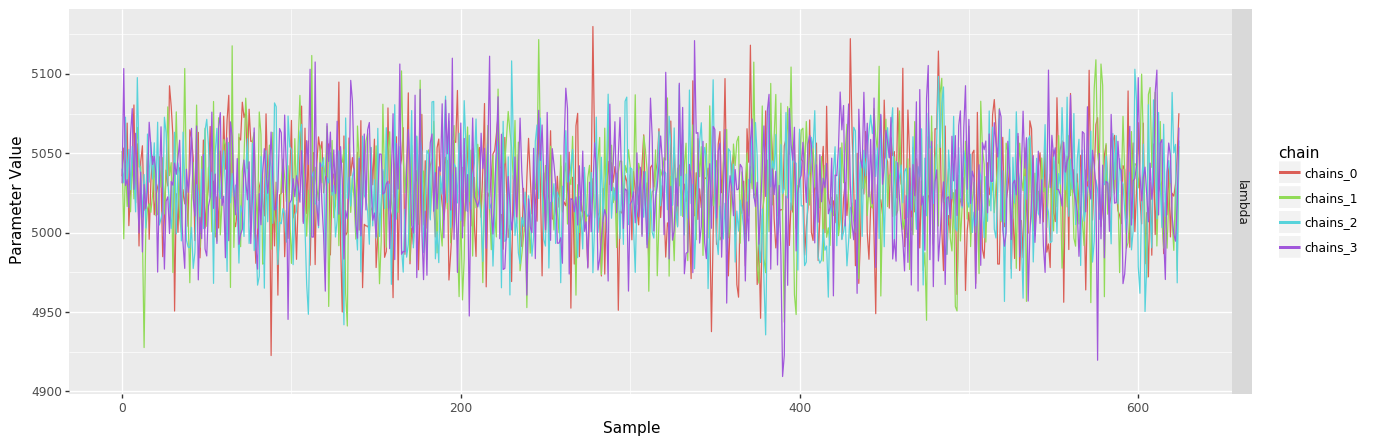

<ggplot: (-9223372036480601975)>


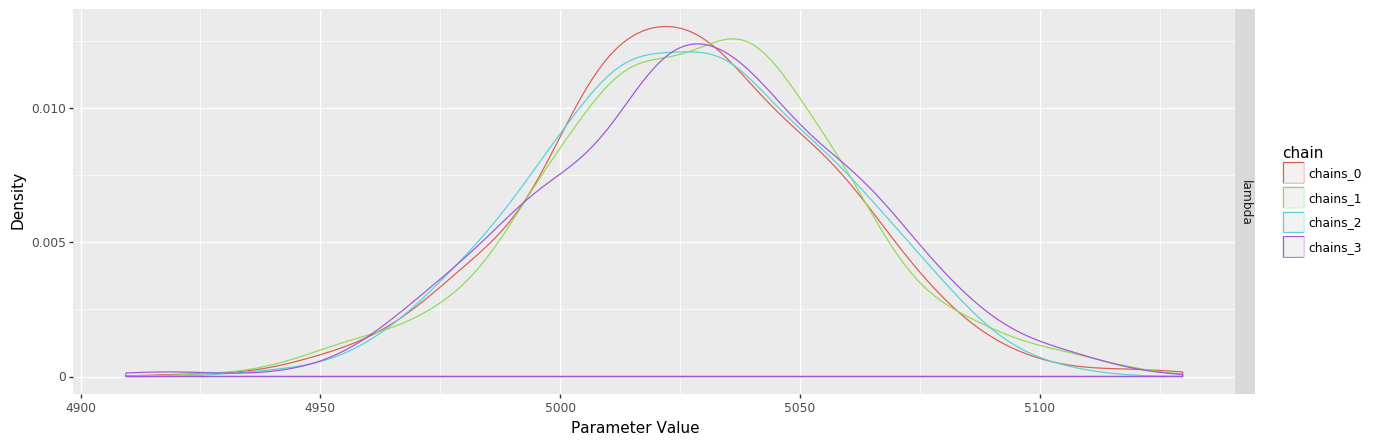

<ggplot: (-9223372036480661174)>


In [14]:
plot_trace(m_c_df)

In [15]:
# Calculating the effective sample size across chains
ess = tfp.mcmc.effective_sample_size(m_c.T)
print('We have {chains} chains and {samples} samples across chains'.format(chains = n_chains,samples = n_samples))
print('The effective sample size across our {a} chains are {b}'.format(a=n_chains, b=np.round(ess).sum()))


We have 4 chains and 625 samples across chains
The effective sample size across our 4 chains are 2268.0


In [16]:
# Gelman Rubin Statistic
# Calculating the Within variance
variance_within = m_c_df.groupby('chain').agg({'value':'var'})
W = variance_within.value.mean()/n_chains
print('The average variance within chains (W) is {}'.format(np.round(W,2)))

# Calculating Between variance
mean_individuals_chains =  m_c_df.groupby('chain').agg({'value':'mean'}).value
B = np.var(mean_individuals_chains)
print('The average variance between chains (B) is {}'.format(np.round(B,2)))

# Calculating the the scale reduction factor
V =  W + B
scale_redution_factor = np.sqrt(V/W)
print('The average scale reduction (R) is {}'.format(np.round(scale_redution_factor,2)))

# Alternatively we could use the built in function within the TF package:
R_tf = tfp.mcmc.potential_scale_reduction(m_c.T, independent_chain_ndims=1)
print('The average scale reduction (R_tf) is {}'.format(np.round(R_tf,2)))

The average variance within chains (W) is 243.93
The average variance between chains (B) is 1.34
The average scale reduction (R) is 1.0
The average scale reduction (R_tf) is 1.0


In [17]:
# Putting the MCMC diagnostics together
def mcmc_diagnostics(m_c, 
                     thin = 1, 
                     srf_details = False, 
                     plot_1_acf = False, 
                     plot_m_c_trace = False):
    
    # Thin sample?
    if thin>1:
        m_c = np.array([chain[::thin] for chain in m_c])
    
    # Constants
    n_chains, n_samples = m_c.shape

    # Reformatting chains
    col_names = ['chains_'+ str(i) for i in range(0,n_chains)]
    col_names = dict(zip(range(0,n_chains),col_names))
    m_c_df = pd.DataFrame(m_c.T).rename(col_names, axis = 1).reset_index().rename({'index':'sample_i'}, axis = 1)
    m_c_df =  pd.melt(m_c_df, id_vars = 'sample_i').assign(parameter = 'lambda').rename({'variable':'chain'}, axis = 1)

    # Plot 1 acf?
    if plot_1_acf:
        print(plot_acf(acf(m_c[0])))

    # Plot trace?
    if plot_m_c_trace:
        print(plot_trace(m_c_df))
    
    # Calculate effective sample size
    ess = tfp.mcmc.effective_sample_size(m_c.T, filter_beyond_positive_pairs=False).numpy().sum()
    print('The effective sample size across our {a} chains are {b}'.format(a=n_chains, b=np.round(ess)))

    # -- Scale reduction factor --
    # Calculating the Within variance
    if srf_details:
        variance_within = m_c_df.groupby('chain').agg({'value':'var'})
        W = variance_within.value.mean()/n_chains
        print('The average variance within chains (W) is {}'.format(np.round(W,2)))

        # Calculating Between variance
        mean_individuals_chains =  m_c_df.groupby('chain').agg({'value':'mean'}).value
        B = np.var(mean_individuals_chains)
        print('The average variance between chains (B) is {}'.format(np.round(B,2)))

        # Calculating the the scale reduction factor
        V = W + B
        R = np.sqrt(V/W)
        print('The average scale reduction (R) is {}'.format(np.round(R,2)))
    else:
        R = tfp.mcmc.potential_scale_reduction(m_c.T, independent_chain_ndims=1)
        print('The average scale reduction (R) is {}'.format(np.round(R,2)))

    # -- Output mean value and variance of parameter --
    flat_m_c = np.round(m_c.flatten(),3)
    summary_vals = {'mean_parameter' : np.mean(flat_m_c),
    'mode_parameter' :  mode(flat_m_c).mode,
    'std_dev_parameter' : np.std(flat_m_c),
    '5_percentile' : np.percentile(flat_m_c,5),
    '95_percentile': np.percentile(flat_m_c,95),
    'n_eff': ess,
    'R': np.round(R.numpy(),2)}
    return(pd.DataFrame(summary_vals))

# Test output
mcmc_diagnostics(m_c, thin = 8)


The effective sample size across our 4 chains are 272.0
The average scale reduction (R) is 1.0


,mean_parameter,mode_parameter,std_dev_parameter,5_percentile,95_percentile,n_eff,R
0,5028.273728,5016.851,31.756657,4972.365,5076.2455,271.846145,1.0


In [18]:
m_c

array([[5035.47294372, 5053.28679624, 5033.83649637, ..., 5030.56730936,
        5048.63624576, 5075.1845208 ],
       [5051.38143652, 4996.11781062, 5043.5686064 , ..., 5028.27122999,
        4976.33783583, 5054.40403136],
       [5040.24547873, 5031.33540892, 5072.72150202, ..., 5055.57790116,
        4968.40023897, 5058.04104827],
       [5031.07120867, 5103.31404086, 5029.72184682, ..., 4994.63458894,
        5017.56360536, 5066.1657947 ]])

In [19]:
# Looking at a larger data set here n = 1000 observed values
y_sim = np.random.poisson(lam=2000, size=1000) # <- Simulated values  

# Generating 4 chains
np.random.seed(123)
n_chains = 4
seeds = np.random.choice(10**5, size = n_chains)
m_c = np.array([metropolis_sampler_poisson_gamma(y_sim,0.005,0.005,5, seed = seeds[i]) for i in range(0,n_chains)]) # thinning number looks like 6

# Test output
mcmc_diagnostics(m_c, thin = 6)

The effective sample size across our 4 chains are 2728.0
The average scale reduction (R) is 1.0


,mean_parameter,mode_parameter,std_dev_parameter,5_percentile,95_percentile,n_eff,R
0,1997.443063,1996.614,1.399167,1995.11525,1999.75525,2727.775427,1.0
